# Classifying Activity Type from Strava Data

Strava is an application that allows users to track data on their exercises and record them for things such as sharing with friends, recording progress, or looking at weekly, monthly, or yearly stats. The data Strava data includes things such as maximum speed, distance traveled, moving time, and elevation gain. And the activities to be predicted are things like running, biking, and swimming.

Here I am going to attempt to classify what type of activity a recorded activity was based on its data. I will be using a Neural Network Classifier based on asignment A4 https://nbviewer.org/url/www.cs.colostate.edu/~cs445/notebooks/A4.2%20Classification%20of%20Hand-Drawn%20Digits.ipynb


The data I will be using is a combination of data from a user on Kaggle found bellow as well as my own strava data.

https://www.kaggle.com/datasets/purpleyupi/strava-data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Lets first load the kaggle dataset in and see what activity types we have to work with

In [ ]:
kaggledf = pd.read_csv("strava_full_data.csv")
kaggledf.head()

,Unnamed: 0,average_speed,max_speed,average_heartrate,max_heartrate,distance,elapsed_time,moving_time,total_elevation_gain,elev_high,type,start_date_local,kudos_count
0,0,3.142,5.3,NaN,NaN,11443.2,1:03:50,1:00:42,73.0,115.0,Run,2020-01-18T12:00:36,12
1,1,3.410,7.4,NaN,NaN,9486.0,0:48:51,0:46:22,36.1,96.9,Run,2020-01-17T19:00:58,13
2,2,3.273,4.0,NaN,NaN,8854.8,0:45:32,0:45:05,16.0,117.2,Run,2020-01-13T18:37:29,3
3,3,3.259,4.0,NaN,NaN,7717.5,0:39:35,0:39:28,10.0,131.6,Run,2020-01-10T18:36:52,2
4,4,3.222,4.0,NaN,NaN,7659.5,0:41:33,0:39:37,12.0,107.4,Run,2020-01-08T18:37:24,17


In [ ]:
types = kaggledf["type"].to_numpy()
activity_types = np.unique(types)
activity_types

array(['AlpineSki', 'Hike', 'Ride', 'RockClimbing', 'Run', 'Swim', 'Walk',
       'WeightTraining', 'Yoga'], dtype=object)

Lets see how the data is spread out between different activity type, some activities may have to few occurances to be usefull.

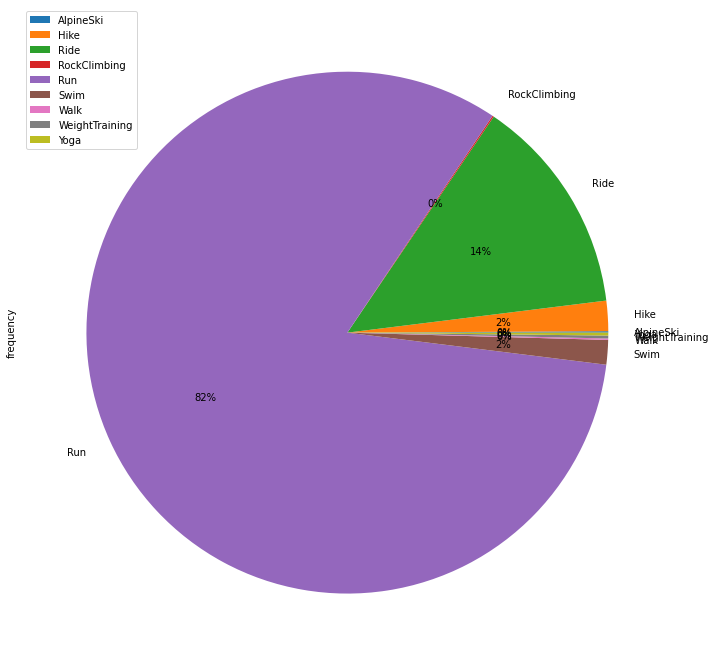

In [ ]:
ones = np.ones(1121)
kaggledf["frequency"] = ones
kaggledf.groupby(['type']).sum().plot(
    kind='pie', y='frequency', autopct='%1.0f%%', figsize=(12, 12))

Looks like we will mostly be focusing on bike rides, runs, possibly hikes and swims, and maybe ill add an other category the model can predict for other activities.






With slightly more hike activities than swim activites I'm going to limit the activity types to 'Run', 'Ride', 'Hike', and 'Other'. Hike only has 22 instances but I think it's worth giving it a shot in the model due to the data's simplicity.

Now lets look at my data. I already deleted some random columns and changed the names to match the kaggle dataset in excel for simplicity.

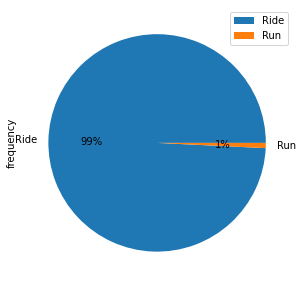

In [ ]:
mydf = pd.read_csv("activities.csv")
types = mydf["type"].to_numpy()
activity_types = np.unique(types)
ones = np.ones(260)
mydf["frequency"] = ones
mydf.groupby(['type']).sum().plot(
    kind='pie', y='frequency', autopct='%1.0f%%', figsize=(5, 5))

Hmmm.. I wonder what my favorite athletic activity is. But the frequency of biking data I have over my one or two runs will pair nicely with the Kaggle dataset having mostly running data. Also Just a quick flex bellow before I start combining the datasets into one dataframe.

In [ ]:
my_max_speeds = mydf["max_speed"].to_numpy()
x=np.sort(my_max_speeds)
my_max_speeds_mph= x*2.2369 #Meters per second to MPH
my_max_speeds_mph[255:]

array([52.34345915, 53.0145317 , 53.2382183 , 55.02774085, 57.4883317 ])

And finally a very generous "anonymous" Strava user also shared their data for this project which should contain some more hiking data which we didn't have enough of before.

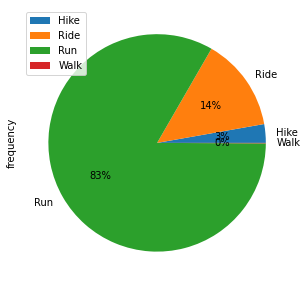

In [ ]:
anondf = pd.read_csv("activities2.csv")
types = anondf["type"].to_numpy()
activity_types = np.unique(types)
ones = np.ones(1440)
anondf["frequency"] = ones
anondf.groupby(['type']).sum().plot(
    kind='pie', y='frequency', autopct='%1.0f%%', figsize=(5, 5))

Funny enough there were exactly 40 hikes in this dataset. This totals out to about 60 hikes which I think will be enough. I will probably do a ride/run/hike model with limited data and a ride/run model with lots of data

Now lets clean the data, right away it seems like a few collumns need to get deleted. 


*   Unnamed: 0 is just the number of the activity
*   average heart rate and max heart rate dont have consitent data.
*   Start date local and kudos count wont have any usefull information in them for classifying the activity type.
*   Average speed is a linear combination of the variables (distance and moving time) so it should be removed

To get rid of the activities we wont be looking at I'm going to replace them with NaNs then just delete all rows with NaNs which will also clean out any other problematic rows.

I also need to convert the kaggle data's time strings (h:m:s) to seconds like my strava data

In [ ]:
#combining the two datasets
stravadf = pd.concat([kaggledf, mydf, anondf], ignore_index=True)

stravadf = stravadf.drop(columns=['Unnamed: 0', 'average_heartrate', 'max_heartrate', 'start_date_local', 'kudos_count', 'frequency', 'average_speed', 'Average Speed'])

#replacing unwanted types with nan to get rows deleted
stravadf = stravadf.replace({'type':['AlpineSki', 'RockClimbing', 'Swim', 'Walk',
       'WeightTraining', 'Yoga']}, np.nan)

stravadf = stravadf.dropna() #get rid of rows with nans
stravadf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2697 entries, 0 to 2820
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   max_speed             2697 non-null   float64
 1   distance              2697 non-null   float64
 2   elapsed_time          2697 non-null   object 
 3   moving_time           2697 non-null   object 
 4   total_elevation_gain  2697 non-null   float64
 5   elev_high             2697 non-null   float64
 6   type                  2697 non-null   object 
dtypes: float64(4), object(3)
memory usage: 168.6+ KB


In [ ]:
from sklearn.utils import shuffle
stravadf = shuffle(stravadf)

#convert times from objects to floats

#code based on: https://stackoverflow.com/questions/6402812/how-to-convert-an-hmmss-time-string-to-seconds-in-python
def get_sec(time_str):
    if type(time_str) == int:
      return time_str

    d = 0

    if("day" in time_str):
      d = float(time_str.partition(" day")[0])
      time_str = time_str.partition(", ")[2]

    h, m, s = str(time_str).split(':')
    return d * 86400 + float(h) * 3600 + float(m) * 60 + float(s)

stravadf['moving_time'] = stravadf['moving_time'].apply(get_sec)
stravadf['elapsed_time'] = stravadf['elapsed_time'].apply(get_sec)



stravadf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2697 entries, 469 to 609
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   max_speed             2697 non-null   float64
 1   distance              2697 non-null   float64
 2   elapsed_time          2697 non-null   float64
 3   moving_time           2697 non-null   float64
 4   total_elevation_gain  2697 non-null   float64
 5   elev_high             2697 non-null   float64
 6   type                  2697 non-null   object 
dtypes: float64(6), object(1)
memory usage: 168.6+ KB


This data set is now usable and it looks like we didnt loose too many rows to NaN values. Now lets take a look at this dataset as a whole

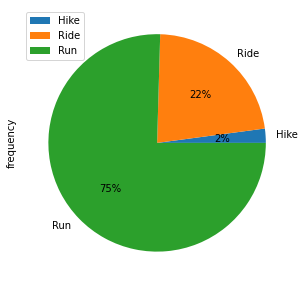

In [ ]:
types = stravadf["type"].to_numpy()
activity_types = np.unique(types)
ones = np.ones(2697)
stravadf["frequency"] = ones
stravadf.groupby(['type']).sum().plot(
    kind='pie', y='frequency', autopct='%1.0f%%', figsize=(5, 5))
stravadf = stravadf.drop(columns=['frequency'])

Well see if this 2% hike has a fighting chance, the model may just find it's more acurate to never guess hike because its seen as rare here. If thats the case I'll limit the data to have even classes

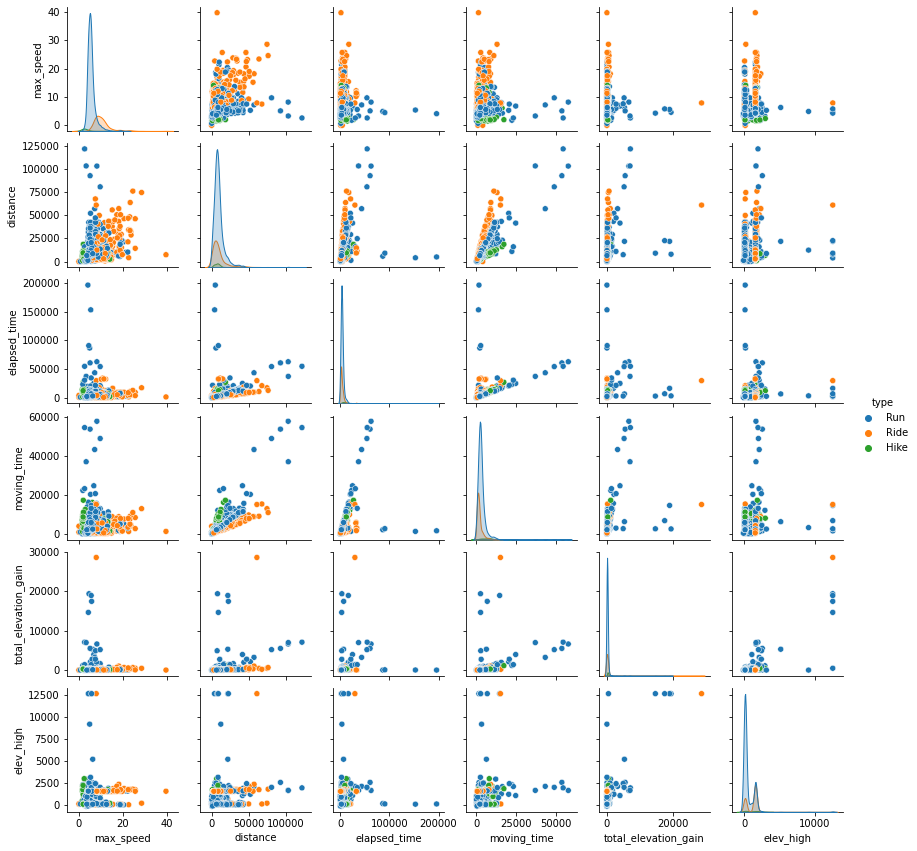

In [ ]:
import seaborn as sns
pallete = sns.color_palette("tab10",3)
sns.pairplot(stravadf, hue="type", height=2.0, palette=pallete)

The first variable that jumps out to me is max speed which I assumed would be an important variable. Clearly people can only run so fast so if a max speed is faster than that threshold, the activity was a ride. And as for hikes they are usually slower than runs which will also help classify the activity type.

Distance may not be a very helpfull as we can see there are runs in the kaggle dataset which come out to around 100 miles long. And you wont find me biking 100miles anytime soon even though it would be much easier to do on a bike.

With the elevation statistics I would expect a far greater elevation gain for hikes as hikes are usually just walks/runs with elevation to them. Mor likely than not the hiking data I have is just not a great representation of different types of hikes.

# Splitting Data

I'm going to be using k fold cross validation to get the most out of the little hiking data I have. 


The code I'll be using for k fold cross validation is from A3: https://colab.research.google.com/drive/14M0dcZO0Vs0zg80oeeL6ErPe7Su2tcSI#scrollTo=OVouQKPaZUBx

In [ ]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

In [ ]:
from sklearn.model_selection import train_test_split

y = stravadf["type"].to_numpy()
X = stravadf.drop(columns=['type']).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_test[:10]#yes there are hikes in here allthough very few

array(['Ride', 'Run', 'Run', 'Run', 'Run', 'Run', 'Ride', 'Run', 'Ride',
       'Run'], dtype=object)

# Neural Network Model
Now I will be using the Neural Network Classifier from A4. I'm using a classifier and not a normal neural network as activity type isn't a continuous variable but a catagorical variable.

I'll first add the optimizers class, then the neural netowrk class which uses the optimizers class to take advantage of stochastic gradient decent while training. Then Neural network classifier will be a child of the normal neural network class through inheritance allowing us to use most of the same features without re writing code.

What changes with a classifier neural network is the variable being predicted is transformed to a dummy variable made of ones and zeros. Each class being predicted has its own unique combination. As well softmax is used as the activation funciton on the last layer. Softmax applies essenitally a confidence to each of the classes and the class with the highest confidence is what is predicted for a given input.

The following code is based on starter code found here: https://nbviewer.org/url/www.cs.colostate.edu/~cs445/notebooks/A4.2%20Classification%20of%20Hand-Drawn%20Digits.ipynb

# Optimizers

In [ ]:
%%writefile optimizers.py
import numpy as np

######################################################################
## class Optimizers()
######################################################################

class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        # The following initializations are only used by adam.
        # Only initializing m, v, beta1t and beta2t here allows multiple calls to adam to handle training
        # with multiple subsets (batches) of training data.
        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1
        self.beta2t = 1

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            self.mt[:] = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt[:] = self.beta2 * self.vt + (1 - self.beta2) * grad * grad
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2

            m_hat = self.mt / (1 - self.beta1t)
            v_hat = self.vt / (1 - self.beta2t)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    
            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

if __name__ == '__main__':

    import matplotlib.pyplot as plt
    plt.ion()

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin):
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin],
                  n_epochs=500, learning_rate=0.1)

    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin],
                   n_epochs=500, learning_rate=0.1)
    
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')

Writing optimizers.py


# Neural Network

In [ ]:
import optimizers
import sys  # for sys.float_info.epsilon

######################################################################
## class NeuralNetwork()
######################################################################

class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.activation_function = activation_function

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs}, \'{self.activation_function}\')'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        result = self.__repr__()
        if len(self.error_trace) > 0:
            return self.__repr__() + f' trained for {len(self.error_trace)} epochs, final training error {self.error_trace[-1]:.4f}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = optimizers.Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units, 
        # but only if the network has a single output. Multiplying by self.Tstds for 
        # multiple outputs does not correctly unstandardize the error.
        if len(self.Tstds) == 1:
            error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar
        else:
            error_convert_f = lambda err: np.sqrt(err)[0] # to scalar
            

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

    def relu(self, s):
        s[s < 0] = 0
        return s

    def grad_relu(self, s):
        return (s > 0).astype(int)
    
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            if self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            else:
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized'''
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(X)
        Y = Ys[-1]
        # Unstandardize output Y before returning it
        return Y * self.Tstds + self.Tmeans

# Neural Network Classifier

In [ ]:
class NeuralNetworkClassifier(NeuralNetwork):
  
    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing

            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        self.class_names = np.unique(T)
        T = self.makeIndicatorVars(T)
        

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = optimizers.Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units, 
        # but only if the network has a single output. Multiplying by self.Tstds for 
        # multiple outputs does not correctly unstandardize the error.
        to_likelihood = lambda nll: np.exp(-nll)
            

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=to_likelihood)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=to_likelihood)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self


    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T- self.softmax(self.Ys[-1])
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        return  -np.mean(T * np.log(self.softmax(self.Ys[-1])))

    def makeIndicatorVars(self, T):#https://nbviewer.org/url/www.cs.colostate.edu/~cs445/notebooks/10%20Classification%20with%20Linear%20Logistic%20Regression.ipynb
        if T.ndim == 1:
            T = T.reshape((-1, 1))    
        return (T == np.unique(T)).astype(int)

    def softmax(self, X):
        g = np.exp(X)
        return g / np.sum(g, axis=1).reshape((-1,1))

    def use(self, X):
        '''X assumed to not be standardized'''
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(X)
        Y = self.softmax(Ys[-1])
        # Unstandardize output Y before returning it
        #return classes[np.argmax(Y, axis =1)].reshape((np.size(Y,0),1))
        classes = self.class_names[np.argmax(Y, axis =1)]
        return classes.reshape(classes.shape[0],-1), np.amax(Y, axis =1)


# Running Tests

Check just to make sure its working then off to testing various models.

Adam: Epoch 20 Error=0.82669
Adam: Epoch 40 Error=0.88435
Adam: Epoch 60 Error=0.89993
Adam: Epoch 80 Error=0.91036
Adam: Epoch 100 Error=0.91978
Adam: Epoch 120 Error=0.92802
Adam: Epoch 140 Error=0.93524
Adam: Epoch 160 Error=0.94106
Adam: Epoch 180 Error=0.94539
Adam: Epoch 200 Error=0.94843


Text(0, 0.5, 'Likelihood')

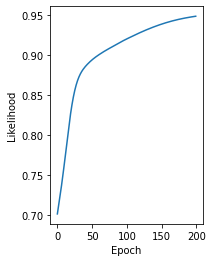

In [ ]:
hiddens = [10]
nnet = NeuralNetworkClassifier(X.shape[1], hiddens, len(np.unique(y)))
nnet.train(X, y, 200, 0.01, method='adam', verbose=True)

plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)
plt.xlabel('Epoch')
plt.ylabel('Likelihood')

In [ ]:
T = y.reshape((2697, 1))
n_folds = 10
list_of_n_hiddens = [[5], [5,3], [10,10], [30,20], [6,3,2], [5, 2, 3]]
n_epochs = 500
learning_rate = .01
act_func = 'adam'

column_names = ['Hidden Layers', 'Train', 'Validate', 'Test']
result_df = pd.DataFrame(columns = column_names)

sumTrainPercCor = 0
sumValidatePercCor = 0
sumTestPercCor = 0

for hiddensi in list_of_n_hiddens:
  for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, n_folds):
    
    nnet = NeuralNetworkClassifier(Xtrain.shape[1], hiddensi, 3)
    nnet.train(Xtrain, Ttrain, 500, learning_rate, method=act_func, verbose=False)

    Y_classes, Y_probs = nnet.use(Xtrain)
    sumTrainPercCor +=  100 * np.mean(Y_classes == Ttrain)
    Y_classes, Y_probs = nnet.use(Xvalidate)
    sumValidatePercCor += 100 * np.mean(Y_classes == Tvalidate)
    Y_classes, Y_probs = nnet.use(Xtest)
    sumTestPercCor += 100 * np.mean(Y_classes == Ttest)

  sumTrainPercCor = sumTrainPercCor/n_folds/10
  sumValidatePercCor = sumValidatePercCor/n_folds/10
  sumTestPercCor = sumTestPercCor/n_folds/10

  row = {'Hidden Layers': hiddensi, 'Train': sumTrainPercCor, 'Validate': sumValidatePercCor, 'Test': sumTestPercCor}
  result_df = result_df.append(row, ignore_index = True)
  
result_df

Streaming output truncated to the last 5000 lines.
Adam: Epoch 50 Error=0.87189
Adam: Epoch 100 Error=0.90742
Adam: Epoch 150 Error=0.92350
Adam: Epoch 200 Error=0.93594
Adam: Epoch 250 Error=0.94434
Adam: Epoch 300 Error=0.94891
Adam: Epoch 350 Error=0.95204
Adam: Epoch 400 Error=0.95530
Adam: Epoch 450 Error=0.95723
Adam: Epoch 500 Error=0.95827
Adam: Epoch 50 Error=0.87220
Adam: Epoch 100 Error=0.90381
Adam: Epoch 150 Error=0.91927
Adam: Epoch 200 Error=0.93332
Adam: Epoch 250 Error=0.94209
Adam: Epoch 300 Error=0.94789
Adam: Epoch 350 Error=0.95189
Adam: Epoch 400 Error=0.95444
Adam: Epoch 450 Error=0.95635
Adam: Epoch 500 Error=0.95787
Adam: Epoch 50 Error=0.87164
Adam: Epoch 100 Error=0.90501
Adam: Epoch 150 Error=0.92280
Adam: Epoch 200 Error=0.93596
Adam: Epoch 250 Error=0.94533
Adam: Epoch 300 Error=0.95077
Adam: Epoch 350 Error=0.95388
Adam: Epoch 400 Error=0.95599
Adam: Epoch 450 Error=0.95751
Adam: Epoch 500 Error=0.95863
Adam: Epoch 50 Error=0.86068
Adam: Epoch 100 Error=0

,Hidden Layers,Train,Validate,Test
0,[5],86.203717,85.863129,85.859218
1,"[5, 3]",87.407722,86.831124,86.694089
2,"[10, 10]",88.000452,87.132897,86.976138
3,"[30, 20]",88.639042,87.028757,86.953074
4,"[6, 3, 2]",86.461003,85.737828,85.725794
5,"[5, 2, 3]",87.036734,86.319592,86.379064


# Confusion Matrix
Lets look at what the model is failing on

In [ ]:
#I cant figure out how to make a confustion matrix from k fold data so im going to 
#     re run a model with the same hidden layer and neuron structure that performed the best
Xtrain, Xtest, Ttrain, Ttest = train_test_split(X, y, test_size=0.33)


nnet = NeuralNetworkClassifier(Xtrain.shape[1], [10,10], 3)
nnet.train(Xtrain, Ttrain, 1000, .01, method='adam', verbose=False)

Y_classes, Y_probs = nnet.use(Xtest)

Adam: Epoch 100 Error=0.93214
Adam: Epoch 200 Error=0.96450
Adam: Epoch 300 Error=0.96873
Adam: Epoch 400 Error=0.97125
Adam: Epoch 500 Error=0.97333
Adam: Epoch 600 Error=0.97530
Adam: Epoch 700 Error=0.97669
Adam: Epoch 800 Error=0.97775
Adam: Epoch 900 Error=0.97864
Adam: Epoch 1000 Error=0.97940


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Ttest, Y_classes)#Hike, Ride, Run

array([[ 14,   0,   4],
       [  1, 174,  19],
       [  6,   9, 664]])

Overall not bad at all this matrix comes out to a 95% acuracy (these numbers obviously change every run so then may not be exact). The hiking acuracy is a little weak being at about 80% here. I could see these numbers being good enough for strava to use. Especially because they would have more data and could train the model further as well.

First I'll see how a model looking at just ride/run does

In [ ]:
runRide = stravadf.replace({'type':['Hike']}, np.nan)
runRide = runRide.dropna() #get rid of hikes

#next two lines based off of https://stackoverflow.com/questions/45839316/pandas-balancing-data
temp = runRide.groupby('type')
runRide = pd.DataFrame(temp.apply(lambda x: x.sample(temp.size().min()).reset_index(drop=True)))

y = runRide["type"].to_numpy()
X = runRide.drop(columns=['type']).to_numpy()

Xtrain, Xtest, Ttrain, Ttest = train_test_split(X, y, test_size=0.33)
nnet = NeuralNetworkClassifier(Xtrain.shape[1], [10,10], 2)
nnet.train(Xtrain, Ttrain, 1000, .01, method='adam', verbose=False)

Y_classes, Y_probs = nnet.use(Xtest)
confusion_matrix(Ttest, Y_classes)#Hike, Ride, Run

Adam: Epoch 100 Error=0.89582
Adam: Epoch 200 Error=0.93842
Adam: Epoch 300 Error=0.94458
Adam: Epoch 400 Error=0.94881
Adam: Epoch 500 Error=0.95389
Adam: Epoch 600 Error=0.95938
Adam: Epoch 700 Error=0.96281
Adam: Epoch 800 Error=0.96543
Adam: Epoch 900 Error=0.96794
Adam: Epoch 1000 Error=0.97015


array([[186,  12],
       [ 16, 186]])

Running this a few times the acuracy is still hovering at around 95% so it seems at least with this model structure weve hit a max acuracy in the mid 90%s which is still great

In [ ]:
evenRRH = stravadf
y = evenRRH["type"].to_numpy()
count1 = (y == "Hike").sum()
count1 #how many hikes we have

57

In [ ]:
#next two lines based off of https://stackoverflow.com/questions/45839316/pandas-balancing-data
temp = evenRRH.groupby('type')
evenRRH = pd.DataFrame(temp.apply(lambda x: x.sample(temp.size().min()).reset_index(drop=True)))
y = evenRRH["type"].to_numpy()
count1 = (y == "Run").sum()
count2 = (y == "Ride").sum()
count3 = (y == "Hike").sum()
count1, count2, count3

(57, 57, 57)

In [ ]:
X = evenRRH.drop(columns=['type']).to_numpy()

Xtrain, Xtest, Ttrain, Ttest = train_test_split(X, y, test_size=0.33)
nnet = NeuralNetworkClassifier(Xtrain.shape[1], [10,10], 3)
nnet.train(Xtrain, Ttrain, 1000, .01, method='adam', verbose=False)

Y_classes, Y_probs = nnet.use(Xtest)
confusion_matrix(Ttest, Y_classes)#Hike, Ride, Run

Adam: Epoch 100 Error=0.93075
Adam: Epoch 200 Error=0.96502
Adam: Epoch 300 Error=0.97839
Adam: Epoch 400 Error=0.99135
Adam: Epoch 500 Error=0.99633
Adam: Epoch 600 Error=0.99809
Adam: Epoch 700 Error=0.99883
Adam: Epoch 800 Error=0.99919
Adam: Epoch 900 Error=0.99940
Adam: Epoch 1000 Error=0.99954


array([[19,  0,  0],
       [ 0, 22,  0],
       [ 1,  2, 13]])

This really suprised me. After seeing the hiking data struggle for so long, especially when I orionally did this with only 17 hikes, its great to see the model get 100% test acuracy on hikes. Obviously with more data it wouldnt come out to 100% but I could see it still doing good

# Conclusion

Well what has all this work acomplished? If implemented to strava it would save users who only ran or rode their bike an extra click each time they did an activity. Which isnt much but it's definetly something I could see a company like Strava doing. Especially because classifying the activity type isnt that complex of a problem. Is my testing acuracy of ~95% usable? I would say yes, because it isnt that big of a deal if the user has to correct it but not having to click the "activity type" button almost every time would be convenient.

I would love to do this with other activities as I could see things with more strange data like swiming or rock climbing being difficult to categorize but I still think a good model could get it correct almost every time.

Is this method of picking what activity the user did more efficient than forcing the user to pick it? Or what about just defaulting to the last activity or the most common activity the user does? That definetly depends on the user. For someone like me who basically only bikes, the method of picking my most frequent activity or previous activity type would prove better results for me than the model. But Strava has many types of activities and many people use it for different things. I think if they implemented this model to pick the activiyy type initially while still allowing the user to change it, it would be convenient. 

Overall I'm happy with the structure of my neural network, I dont see fine tuning it getting me that much further in terms of accuracy. And with the somewhat limited data I had I feel like I definetly got the most use out of it that I reasonably could.